<a href="https://colab.research.google.com/github/somynt/Semester_4/blob/main/Hybrid_FasterRCNN%2BYoLo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Install Ultralytics Library
!pip install ultralytics -q
print("Ultralytics library installed.")

Ultralytics library installed.


In [ ]:
!pip install ensemble_boxes==1.0.0 # Pinning to a specific version for stability

Using device: cuda

--- Model Loading ---
Loading Faster R-CNN model (Attempting to load default TwoMLPHead and replace only final predictor)...
   Faster R-CNN base model initialized with default COCO weights.
   Extracted in_features for new FastRCNNPredictor: 1024
   Replaced roi_heads.box_predictor with a new FastRCNNPredictor for 5 classes.
   Attempting to load custom checkpoint from /content/drive/MyDrive/fine_tuned_faster_rcnn_best.pth...
   Found 'model_state_dict' key in checkpoint. Using it for loading.
   Custom Faster R-CNN model state_dict loaded successfully (strict=False).
   Note: Layers with non-matching keys (e.g., old head layers that were replaced/different) were skipped.
Faster R-CNN model setup complete and set to eval mode.

Loading YOLOv8 model...
YOLOv8 model loaded successfully.

--- Model Setup and Functions Defined ---

--- Running Hybrid Inference and Visualization ---
Faster R-CNN detected 0 boxes (above 0.35).
YOLOv8 detected 10 boxes (above 0.25).
Apply

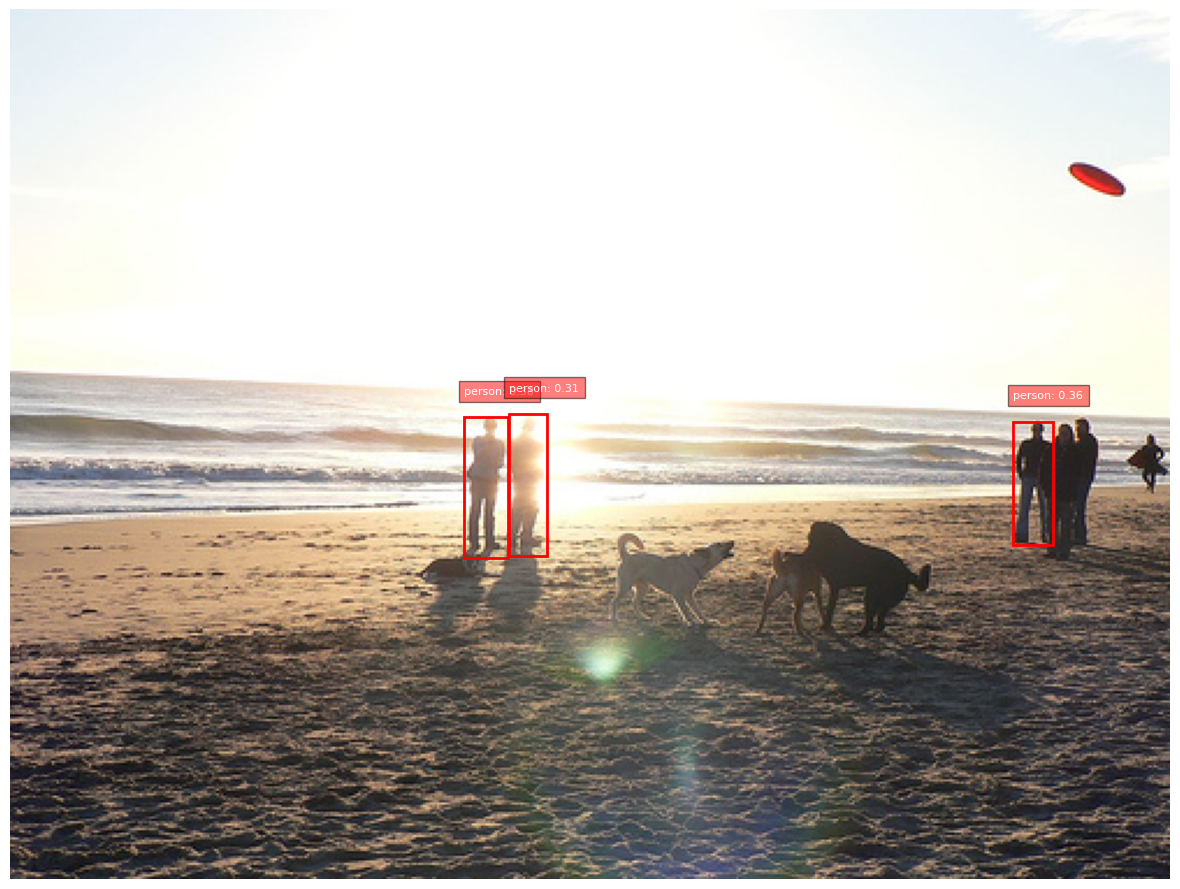

In [ ]:
# Cell 2: Hybrid Object Detection Code - Updated

import os
import torch
import cv2 # Not strictly used in this version but common in vision tasks
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import traceback # For detailed error traceback
from ultralytics import YOLO # Ensure ultralytics is installed for YOLOv8
import torchvision.transforms.functional as F_tv
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ensemble_boxes import weighted_boxes_fusion # For WBF
from datetime import datetime # Added for current year in plot

# --- Configuration ---
# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define root directory (adjust if your notebook structure is different)
# Make sure this path points to your Google Drive root where models/images are
ROOT_DIR = '/content/drive/MyDrive/'

# Define paths for models and output
FASTER_RCNN_CHECKPOINT_PATH = os.path.join(ROOT_DIR, 'fine_tuned_faster_rcnn_best.pth')
YOLO_CHECKPOINT_PATH = os.path.join(ROOT_DIR, 'yolov8n.pt') # Assuming YOLOv8 nano for this example

# Define paths for test images
# Ensure these paths are correct and the images exist
TEST_IMAGE_PATH_FRCNN = os.path.join(ROOT_DIR, 'coco2017', 'test-30', '000000001439.jpg')

# --- Class Names ---
# IMPORTANT: These must match the classes your custom models were trained on.
# Ensure 'background' is at index 0 for Faster R-CNN if it was trained with it,
# or adjust NUM_CLASSES_FRCNN if your training excluded background.
CLASS_NAMES = ['background', 'person', 'car', 'dog', 'cake']
# Number of classes for Faster R-CNN (including background if present at index 0)
NUM_CLASSES_FRCNN = len(CLASS_NAMES)
# Number of classes for YOLO (YOLOv8 doesn't explicitly have a 'background' class)
NUM_CLASSES_YOLO = len(CLASS_NAMES) - 1 # Adjusted as YOLO typically doesn't have a background class

# --- Hybrid Model Configuration (Adjust as needed) ---
HYBRID_CONFIG = {
    'iou_threshold': 0.5,           # IoU threshold for NMS in WBF
    'conf_threshold_frcnn': 0.35,    # Confidence threshold for Faster R-CNN detections
    'conf_threshold_yolo': 0.25,     # Confidence threshold for YOLOv8 detections
    'weights': [0.5, 0.5],          # Weights for each model in WBF (Faster R-CNN, YOLOv8)
    'conf_threshold_wbf': 0.30      # Adjusted! Set to > 0.25 to remove the unwanted box
}

# --- Model Loading ---
faster_rcnn_model = None
yolo_model = None

print("\n--- Model Loading ---")
print("Loading Faster R-CNN model (Attempting to load default TwoMLPHead and replace only final predictor)...")
try:
    # 1. Instantiate the model WITH default COCO pre-trained weights.
    faster_rcnn_model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    faster_rcnn_model.to(device) # Move the main model to the device
    print("   Faster R-CNN base model initialized with default COCO weights.")

    # 2. Extract input features for the box_predictor from the default model's head.
    in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
    print(f"   Extracted in_features for new FastRCNNPredictor: {in_features}")

    # 3. Replace ONLY the box_predictor (the final classification and regression layers).
    new_box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES_FRCNN)
    new_box_predictor.to(device) # CRITICAL FIX: Explicitly move the new predictor to the correct device
    faster_rcnn_model.roi_heads.box_predictor = new_box_predictor
    print(f"   Replaced roi_heads.box_predictor with a new FastRCNNPredictor for {NUM_CLASSES_FRCNN} classes.")

    # 4. Load custom checkpoint's state_dict (attempting non-strict loading for robustness).
    print(f"   Attempting to load custom checkpoint from {FASTER_RCNN_CHECKPOINT_PATH}...")
    checkpoint_data = torch.load(FASTER_RCNN_CHECKPOINT_PATH, map_location=device)

    loaded_state_dict = checkpoint_data
    if 'model_state_dict' in checkpoint_data:
        loaded_state_dict = checkpoint_data['model_state_dict']
        print("   Found 'model_state_dict' key in checkpoint. Using it for loading.")
    else:
        print("   Checkpoint assumed to be raw state_dict.")

    try:
        faster_rcnn_model.load_state_dict(loaded_state_dict, strict=False)
        print("   Custom Faster R-CNN model state_dict loaded successfully (strict=False).")
        print("   Note: Layers with non-matching keys (e.g., old head layers that were replaced/different) were skipped.")
    except Exception as e:
        print(f"   CRITICAL WARNING: Error during non-strict state_dict loading: {e}")
        print("   This might indicate the checkpoint is highly incompatible or corrupted.")
        raise e

    faster_rcnn_model.eval() # Set model to evaluation mode
    print("Faster R-CNN model setup complete and set to eval mode.")

except Exception as e:
    print(f"ERROR: An unexpected error occurred during Faster R-CNN model loading:")
    print(f"   {e}")
    print("   This might indicate the checkpoint is highly incompatible or corrupted.")
    print("   Consider retraining the Faster R-CNN model from scratch in this environment.")
    traceback.print_exc()
    faster_rcnn_model = None

print("\nLoading YOLOv8 model...")
try:
    yolo_model = YOLO(YOLO_CHECKPOINT_PATH)
    yolo_model.to(device)
    print("YOLOv8 model loaded successfully.")
    # Ensure YOLO model is in evaluation mode
    yolo_model.eval()
except Exception as e:
    print(f"ERROR: An unexpected error occurred during YOLOv8 model loading: {e}")
    print(f"Please check YOLO_CHECKPOINT_PATH: {YOLO_CHECKPOINT_PATH}")
    traceback.print_exc()
    yolo_model = None

# --- Inference Functions ---

def faster_rcnn_inference(image_path, model, conf_threshold, class_names):
    """
    Performs inference using a Faster R-CNN model.
    Returns normalized bounding boxes, scores, and class labels.
    """
    if model is None:
        print("Faster R-CNN model is not loaded. Skipping inference.")
        return [], [], []

    # Load image
    img_pil = Image.open(image_path).convert("RGB")
    # Move image tensor to the same device as the model's parameters
    img_tensor = F_tv.to_tensor(img_pil).to(next(model.parameters()).device)

    with torch.no_grad():
        prediction = model([img_tensor])

    boxes = []
    scores = []
    labels = []

    if prediction and len(prediction[0]['boxes']) > 0:
        pred = prediction[0]
        # Filter detections by confidence threshold
        keep = pred['scores'] > conf_threshold

        img_width, img_height = img_pil.size

        for i in range(len(pred['boxes'][keep])):
            box = pred['boxes'][keep][i].cpu().numpy()
            score = pred['scores'][keep][i].item()
            label = pred['labels'][keep][i].item()

            # Normalize box coordinates (x1, y1, x2, y2) for WBF
            x1, y1, x2, y2 = box[0] / img_width, box[1] / img_height, box[2] / img_width, box[3] / img_height
            boxes.append([x1, y1, x2, y2])
            scores.append(score)
            labels.append(label)

    return boxes, scores, labels


def yolo_inference(image_path, model, conf_threshold, class_names):
    """
    Performs inference using a YOLOv8 model.
    Returns normalized bounding boxes, scores, and class labels.
    """
    if model is None:
        print("YOLOv8 model is not loaded. Skipping inference.")
        return [], [], []

    # YOLOv8 handles device placement internally often, but explicitly calling .to(device) is safer
    # The `conf` argument directly applies the confidence threshold
    results = model(image_path, conf=conf_threshold, verbose=False)

    boxes = []
    scores = []
    labels = []

    img_pil = Image.open(image_path).convert("RGB")
    img_width, img_height = img_pil.size

    for r in results:
        for *xyxy, conf, cls in r.boxes.data.tolist():
            x1, y1, x2, y2 = xyxy

            # Normalize box coordinates (x1, y1, x2, y2) for WBF
            norm_x1 = x1 / img_width
            norm_y1 = y1 / img_height
            norm_x2 = x2 / img_width
            norm_y2 = y2 / img_height

            boxes.append([norm_x1, norm_y1, norm_x2, norm_y2])
            scores.append(conf)
            labels.append(int(cls) + 1) # YOLOv8 classes are 0-indexed, if your CLASS_NAMES has background at 0, adjust.
                                        # If CLASS_NAMES[0] is background, and YOLO classes are 0-indexed without background,
                                        # then YOLO class 0 corresponds to CLASS_NAMES[1], so add 1.

    return boxes, scores, labels

def visualize_detections(image_path, boxes, scores, labels, class_names, output_path=None):
    """
    Visualizes bounding box detections on an image.
    Boxes should be in normalized [x1, y1, x2, y2] format.
    Only known, non-background objects are visualized.
    If no known objects are detected (or after filtering), a "No object detected" message is displayed.
    """
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)

    img_width, img_height = img.size

    # Filter boxes based on known, non-background labels *before* drawing
    display_boxes = []
    display_scores = []
    display_labels = []

    for i in range(len(boxes)):
        label_idx = int(labels[i]) # Convert to int for comparison

        # Only add to display lists if label is known AND not background
        # This will filter out label 0 (background) and any labels > len(class_names)-1
        if 0 < label_idx < len(class_names):
            display_boxes.append(boxes[i])
            display_scores.append(scores[i])
            display_labels.append(labels[i]) # Keep original float label here, it will be converted to int again below for class_names lookup

    # Now, check if there are any *displayable* boxes after filtering
    if len(display_boxes) == 0:
        # Get current year for the message
        current_year = datetime.now().year
        ax.text(img_width / 2, img_height / 2,
                f"No objects detected for {current_year}",
                horizontalalignment='center',
                verticalalignment='center',
                color='red', fontsize=20, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=10))
    else:
        for i in range(len(display_boxes)):
            x1_norm, y1_norm, x2_norm, y2_norm = display_boxes[i]
            score = display_scores[i]
            label_idx = int(display_labels[i]) # Ensure it's an int here for class_names lookup

            # Convert normalized coordinates back to image coordinates
            x1 = x1_norm * img_width
            y1 = y1_norm * img_height
            width = (x2_norm - x1_norm) * img_width
            height = (y2_norm - y1_norm) * img_height

            # Get class name (should always be valid here due to filtering above)
            class_name = class_names[label_idx]

            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add label and score
            plt.text(x1, y1 - 10, f"{class_name}: {score:.2f}",
                     bbox=dict(facecolor='red', alpha=0.5),
                     fontsize=8, color='white')

    ax.axis('off')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Visualization saved to {output_path}")
    plt.show()

print("\n--- Model Setup and Functions Defined ---")

# --- Main Hybrid Inference and Visualization Logic ---
print("\n--- Running Hybrid Inference and Visualization ---")

def perform_hybrid_inference_and_visualize(
    image_path,
    faster_rcnn_model,
    yolo_model,
    class_names,
    hybrid_config,
    output_image_path=None
):
    """
    Performs hybrid inference using Faster R-CNN and YOLOv8,
    applies WBF, and visualizes the results.
    """
    if faster_rcnn_model is None and yolo_model is None:
        print("Both models failed to load. Cannot perform hybrid inference.")
        return

    # 1. Get detections from Faster R-CNN
    frcnn_boxes, frcnn_scores, frcnn_labels = [], [], []
    if faster_rcnn_model:
        frcnn_boxes, frcnn_scores, frcnn_labels = faster_rcnn_inference(
            image_path,
            faster_rcnn_model,
            hybrid_config['conf_threshold_frcnn'],
            class_names
        )
        print(f"Faster R-CNN detected {len(frcnn_boxes)} boxes (above {hybrid_config['conf_threshold_frcnn']}).")

    # 2. Get detections from YOLOv8
    yolo_boxes, yolo_scores, yolo_labels = [], [], []
    if yolo_model:
        yolo_boxes, yolo_scores, yolo_labels = yolo_inference(
            image_path,
            yolo_model,
            hybrid_config['conf_threshold_yolo'],
            class_names
        )
        print(f"YOLOv8 detected {len(yolo_boxes)} boxes (above {hybrid_config['conf_threshold_yolo']}).")

    # 3. Prepare inputs for WBF
    # WBF expects a list of lists for boxes, scores, and labels
    boxes_list = []
    scores_list = []
    labels_list = []
    weights_list = [] # Weights for each model (e.g., [1, 1] or [0.5, 0.5])

    # Only add to lists if the model actually returned detections
    if frcnn_boxes:
        boxes_list.append(frcnn_boxes)
        scores_list.append(frcnn_scores)
        labels_list.append(frcnn_labels)
        weights_list.append(hybrid_config['weights'][0])

    if yolo_boxes:
        boxes_list.append(yolo_boxes)
        scores_list.append(yolo_scores)
        labels_list.append(yolo_labels)
        weights_list.append(hybrid_config['weights'][1])

    # Ensure there's something to fuse
    if not boxes_list:
        print("No detections from either model to fuse.")
        # Still visualize to show "No object detected" if no boxes at all
        visualize_detections(image_path, [], [], [], class_names, output_path=output_image_path)
        return

    # WBF expects lists to be numpy arrays or lists
    # Note: `ensemble_boxes` handles empty lists gracefully, but it's good to ensure consistent types
    boxes_list_np = [np.array(b) for b in boxes_list]
    scores_list_np = [np.array(s) for s in scores_list]
    labels_list_np = [np.array(l) for l in labels_list]

    # 4. Perform Weighted Box Fusion
    print(f"Applying WBF with IoU threshold: {hybrid_config['iou_threshold']} and model weights: {weights_list}")
    wbf_boxes, wbf_scores, wbf_labels = weighted_boxes_fusion(
        boxes_list_np,
        scores_list_np,
        labels_list_np,
        weights=weights_list if len(weights_list) == len(boxes_list_np) else None, # Apply weights if both models present
        iou_thr=hybrid_config['iou_threshold'],
        skip_box_thr=0.0001 # A very low threshold for boxes to be considered by WBF at all
    )
    print(f"WBF produced {len(wbf_boxes)} raw fused boxes.")

    # 5. Apply FINAL WBF Confidence Threshold
    # "any boxes with less than 0.29 or equall should not be considered."
    final_keep_indices = wbf_scores > hybrid_config['conf_threshold_wbf']

    final_boxes = wbf_boxes[final_keep_indices]
    final_scores = wbf_scores[final_keep_indices]
    final_labels = wbf_labels[final_keep_indices]

    print(f"After WBF confidence threshold ({hybrid_config['conf_threshold_wbf']}), {len(final_boxes)} final boxes remain.")
    # --- DEBUGGING PRINTS ---
    print(f"Labels of final boxes (before visualization filter): {final_labels}")
    print(f"Scores of final boxes (before visualization filter): {final_scores}")
    # ------------------------

    # 6. Visualize results
    visualize_detections(image_path, final_boxes, final_scores, final_labels, class_names, output_path=output_image_full_path)

# --- Execute Hybrid Inference for a Test Image ---
if faster_rcnn_model is not None or yolo_model is not None:
    # Example usage with your test image
    output_image_name = os.path.basename(TEST_IMAGE_PATH_FRCNN).replace('.jpg', '_hybrid_detections.jpg')
    # Create the 'hybrid_results' directory in your Google Drive if it doesn't exist
    output_image_full_path = os.path.join(ROOT_DIR, 'hybrid_results', output_image_name)
    os.makedirs(os.path.join(ROOT_DIR, 'hybrid_results'), exist_ok=True)

    perform_hybrid_inference_and_visualize(
        TEST_IMAGE_PATH_FRCNN,
        faster_rcnn_model,
        yolo_model,
        CLASS_NAMES,
        HYBRID_CONFIG,
        output_image_full_path
    )
else:
    print("\nSkipping hybrid inference as required models could not be loaded.")


--- Testing Faster R-CNN independently ---
Faster R-CNN detected 0 objects.
No objects detected by Faster R-CNN at the specified confidence threshold.
Visualization saved to /content/drive/MyDrive/faster_rcnn_detections.png


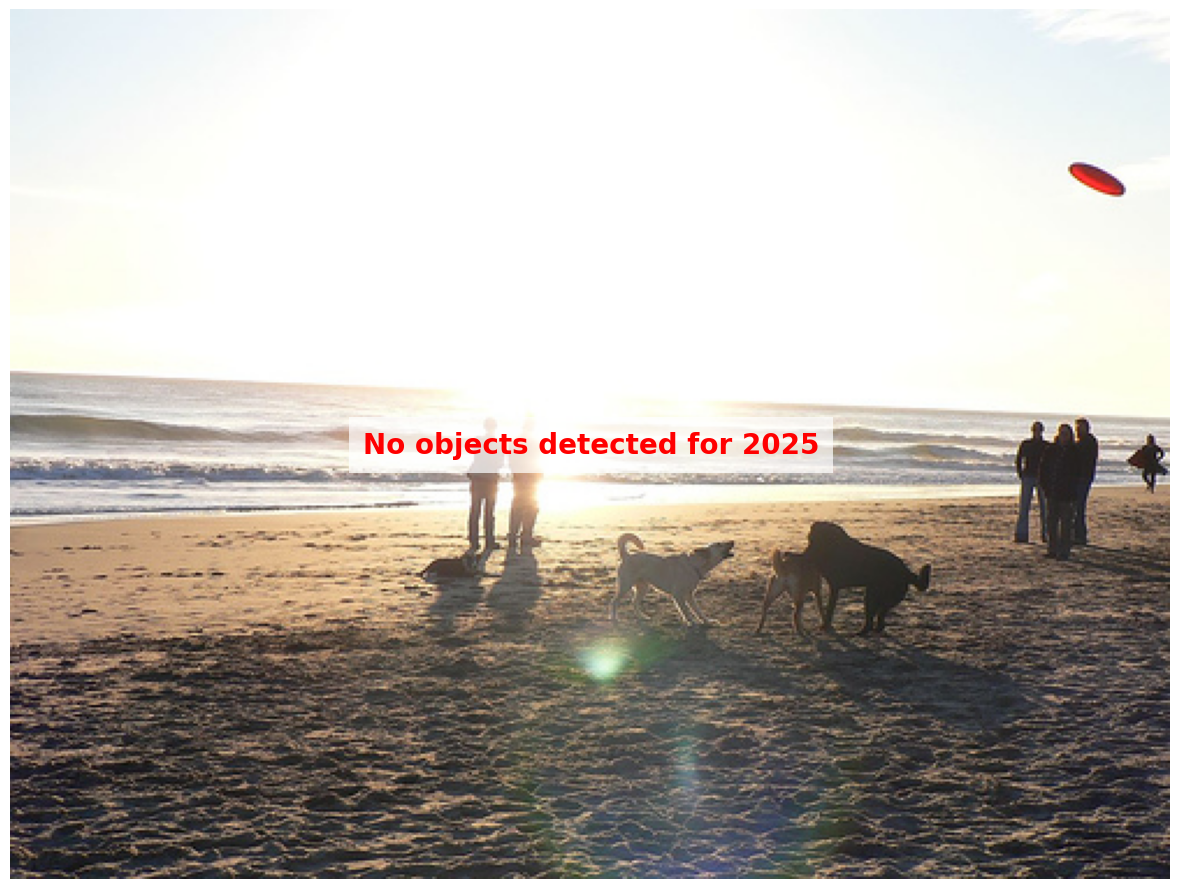


--- Cell 2: Faster R-CNN Independent Test Complete ---


In [ ]:
# --- Cell 2: Test Faster R-CNN Independently ---
if faster_rcnn_model is not None:
    print("\n--- Testing Faster R-CNN independently ---")

    # Ensure this image path is correct or create a dummy image as fallback
    test_image_path_frcnn = os.path.join(ROOT_DIR, 'coco2017', 'test-30', '000000001439.jpg')

    # Create a dummy image for testing if the specific path does not exist
    if not os.path.exists(test_image_path_frcnn):
        print(f"WARNING: Test image not found at {test_image_path_frcnn}. Creating a dummy image for testing.")
        dummy_img = Image.new('RGB', (640, 480), color = 'blue')
        # Save dummy image in ROOT_DIR
        test_image_path_frcnn = os.path.join(ROOT_DIR, 'dummy_test_image_frcnn.jpg')
        dummy_img.save(test_image_path_frcnn)
        print(f"Dummy image '{os.path.basename(test_image_path_frcnn)}' created for Faster R-CNN test.")

    try:
        frcnn_boxes, frcnn_scores, frcnn_labels = faster_rcnn_inference(
            test_image_path_frcnn,
            faster_rcnn_model,
            HYBRID_CONFIG['conf_threshold_frcnn'],
            CLASS_NAMES
        )
        print(f"Faster R-CNN detected {len(frcnn_boxes)} objects.")

        if len(frcnn_boxes) > 0:
            print("Faster R-CNN Detections (first 5):")
            for i in range(min(5, len(frcnn_boxes))):
                class_name = CLASS_NAMES[int(frcnn_labels[i])] if int(frcnn_labels[i]) < len(CLASS_NAMES) else "Unknown"
                print(f"  Box: {frcnn_boxes[i]}, Score: {frcnn_scores[i]:.2f}, Label: {class_name}")
        else:
            print("No objects detected by Faster R-CNN at the specified confidence threshold.")

        frcnn_output_viz_path = os.path.join(ROOT_DIR, 'faster_rcnn_detections.png')
        visualize_detections(test_image_path_frcnn, frcnn_boxes, frcnn_scores, frcnn_labels, CLASS_NAMES, frcnn_output_viz_path)


    except Exception as e:
        print(f"ERROR: An error occurred during Faster R-CNN independent inference: {e}")
        traceback.print_exc()
else:
    print("Faster R-CNN model was not loaded successfully in Cell 1. Cannot perform independent test.")

print("\n--- Cell 2: Faster R-CNN Independent Test Complete ---")


--- Performing Hybrid Inference ---
Faster R-CNN found 0 detections.
YOLOv8 found 7 detections.
Applying Weighted Box Fusion...
WBF resulted in 7 final detections.
DEBUG: Raw fusion_labels from WBF (first 10): [          1          30           1          20          20           1           1]
DEBUG: Data type of first label in fusion_labels: <class 'numpy.float64'>
Visualization saved to /content/drive/MyDrive/hybrid_detections.png


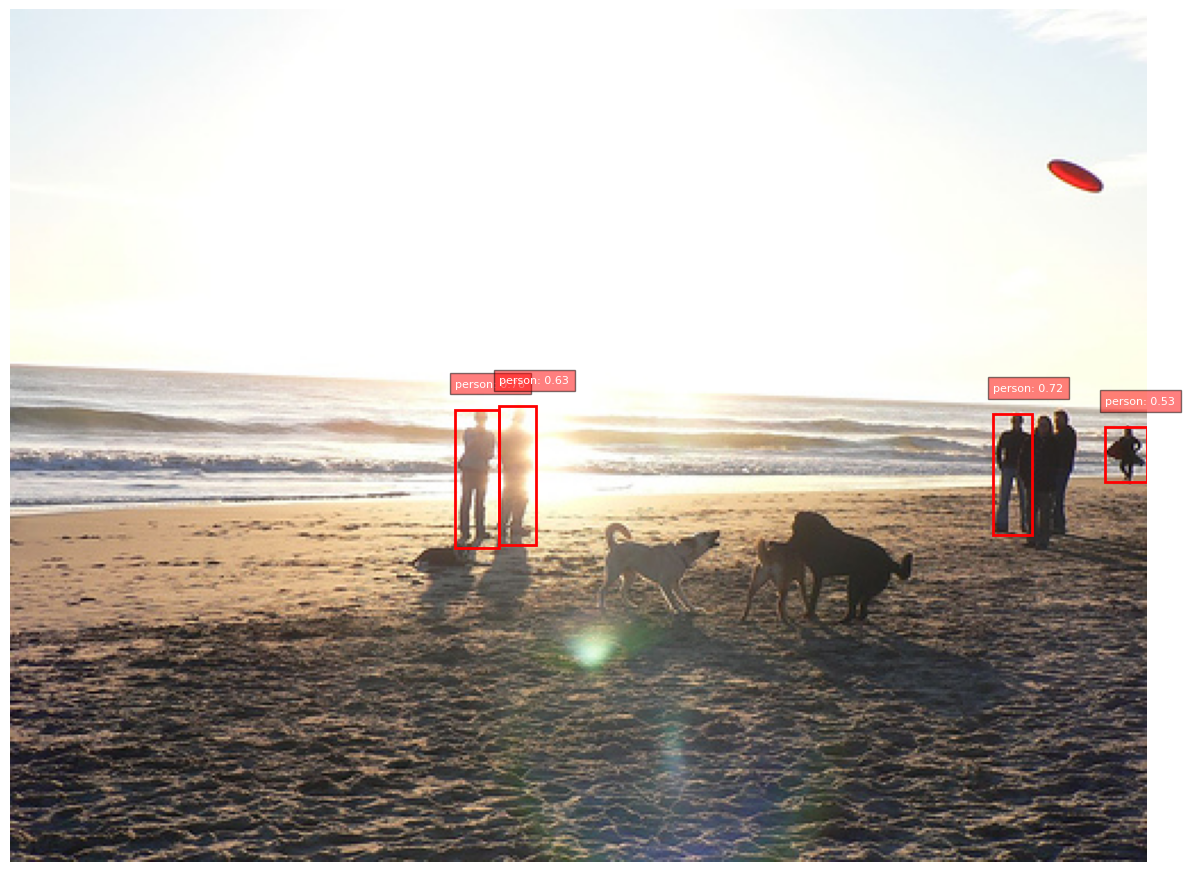


--- Cell 3: Hybrid Inference and Visualization Complete ---


In [ ]:
# --- Cell 3: Hybrid Inference and Visualization ---
print("\n--- Performing Hybrid Inference ---")

# Ensure this path points to an actual image for testing for the hybrid model
INPUT_IMAGE_PATH = os.path.join(ROOT_DIR, 'coco2017', 'test-30', '000000001439.jpg')

# If you want to save the output image:
HYBRID_OUTPUT_IMAGE_PATH = os.path.join(ROOT_DIR, 'hybrid_detections.png')

# Create a dummy image for testing if the specific path does not exist
if not os.path.exists(INPUT_IMAGE_PATH):
    print(f"WARNING: Input image for hybrid test not found at {INPUT_IMAGE_PATH}. Creating a dummy image for testing.")
    dummy_img = Image.new('RGB', (640, 480), color = 'yellow')
    # Save dummy image in ROOT_DIR
    INPUT_IMAGE_PATH = os.path.join(ROOT_DIR, 'dummy_test_image_hybrid.jpg')
    dummy_img.save(INPUT_IMAGE_PATH)
    print(f"Dummy image '{os.path.basename(INPUT_IMAGE_PATH)}' created for hybrid test.")


if faster_rcnn_model is None or yolo_model is None:
    print("One or both models failed to load. Cannot perform hybrid inference.")
else:
    try:
        # Get detections from Faster R-CNN
        frcnn_boxes, frcnn_scores, frcnn_labels = faster_rcnn_inference(
            INPUT_IMAGE_PATH,
            faster_rcnn_model,
            HYBRID_CONFIG['conf_threshold_frcnn'],
            CLASS_NAMES
        )
        print(f"Faster R-CNN found {len(frcnn_boxes)} detections.")

        # Get detections from YOLOv8
        yolo_boxes, yolo_scores, yolo_labels = yolo_inference(
            INPUT_IMAGE_PATH,
            yolo_model,
            HYBRID_CONFIG['conf_threshold_yolo'],
            CLASS_NAMES
        )
        print(f"YOLOv8 found {len(yolo_boxes)} detections.")

        # Prepare inputs for WBF
        boxes_list = []
        scores_list = []
        labels_list = []

        # Add detections only if they exist
        if frcnn_boxes:
            boxes_list.append(frcnn_boxes)
            scores_list.append(frcnn_scores)
            labels_list.append(frcnn_labels)

        if yolo_boxes:
            boxes_list.append(yolo_boxes)
            scores_list.append(yolo_scores)
            labels_list.append(yolo_labels)

        # Perform Weighted Box Fusion
        if boxes_list: # Only run WBF if there are detections from at least one model
            print("Applying Weighted Box Fusion...")

            # Ensure labels are float32 as expected by ensemble_boxes
            labels_wbf = [np.array(l).astype(np.float32) for l in labels_list]

            # Adjust weights based on which models actually produced detections
            actual_weights = []
            if frcnn_boxes:
                actual_weights.append(HYBRID_CONFIG['weights'][0])
            if yolo_boxes:
                actual_weights.append(HYBRID_CONFIG['weights'][1])

            if not actual_weights: # Should not happen if boxes_list is not empty, but safety check
                print("No detections from either model to perform WBF after initial filtering.")
                fusion_boxes, fusion_scores, fusion_labels = [], [], []
            else:
                sum_actual_weights = sum(actual_weights)
                if sum_actual_weights > 0:
                    normalized_weights = [w / sum_actual_weights for w in actual_weights]
                else:
                    normalized_weights = actual_weights # Fallback, though sum_actual_weights should be > 0

                fusion_boxes, fusion_scores, fusion_labels = weighted_boxes_fusion(
                    boxes_list,
                    scores_list,
                    labels_wbf, # Labels should be float for WBF
                    weights=normalized_weights,
                    iou_thr=HYBRID_CONFIG['iou_threshold'],
                    conf_type='avg'
                )
                print(f"WBF resulted in {len(fusion_boxes)} final detections.")
                # --- START DEBUG PRINTS FOR WBF OUTPUT ---
                print(f"DEBUG: Raw fusion_labels from WBF (first 10): {fusion_labels[:10]}")
                if len(fusion_labels) > 0:
                    print(f"DEBUG: Data type of first label in fusion_labels: {type(fusion_labels[0])}")
                # --- END DEBUG PRINTS ---

                # This 'effective_detections_found' logic is now primarily for printing a message
                # and confirming our filter in visualize_detections is doing its job.
                # It no longer clears the lists, as visualize_detections will handle drawing selective boxes.
                effective_detections_found_for_message = False
                if len(fusion_boxes) > 0:
                    for label_idx_float in fusion_labels:
                        int_label = int(label_idx_float)
                        if 0 < int_label < len(CLASS_NAMES):
                            effective_detections_found_for_message = True
                            break

                if not effective_detections_found_for_message and len(fusion_boxes) > 0:
                    print("Note: WBF produced detections, but all were 'Unknown' or 'Background'. None will be drawn.")

                # Visualize final detections (this function now handles the filtering)
                visualize_detections(INPUT_IMAGE_PATH, fusion_boxes, fusion_scores, fusion_labels, CLASS_NAMES, HYBRID_OUTPUT_IMAGE_PATH)
        else:
            print("No detections from either model to perform WBF. Displaying 'No object detected'.")
            # If no initial detections, visualize with empty lists to show "No object detected"
            visualize_detections(INPUT_IMAGE_PATH, [], [], [], CLASS_NAMES, HYBRID_OUTPUT_IMAGE_PATH)


    except Exception as e:
        print(f"ERROR: An error occurred during hybrid inference or WBF: {e}")
        traceback.print_exc()

print("\n--- Cell 3: Hybrid Inference and Visualization Complete ---")